
### TODO

- Visuals to decide which Scalar to use
- Data epxoeration to decide which Model use, or what to tune

# Home load approval prediction
## 1. Problem Defintion
predicting home load approvals

## 2. Data
Train: https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/master/data/loan_sanction_test.csv
Test: https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/master/data/loan_sanction_test.csv
## 3. Evaluation
## 4. Features


In [409]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



# we want our plots to appear inside the notebook
%matplotlib inline


In [410]:
train_url = "https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/master/data/loan_sanction_train.csv"
test_url = "https://raw.githubusercontent.com/tseth4/loan-approval-capstone/refs/heads/master/data/loan_sanction_test.csv"

df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

print("-- Train ----------- ")

print(df.head().T)
print(" ")
print("-- Test ----------- ")
print(test_df.head().T)

-- Train ----------- 
                          0         1         2             3         4
Loan_ID            LP001002  LP001003  LP001005      LP001006  LP001008
Gender                 Male      Male      Male          Male      Male
Married                  No       Yes       Yes           Yes        No
Dependents                0         1         0             0         0
Education          Graduate  Graduate  Graduate  Not Graduate  Graduate
Self_Employed            No        No       Yes            No        No
ApplicantIncome        5849      4583      3000          2583      6000
CoapplicantIncome       0.0    1508.0       0.0        2358.0       0.0
LoanAmount              NaN     128.0      66.0         120.0     141.0
Loan_Amount_Term      360.0     360.0     360.0         360.0     360.0
Credit_History          1.0       1.0       1.0           1.0       1.0
Property_Area         Urban     Rural     Urban         Urban     Urban
Loan_Status               Y         N     

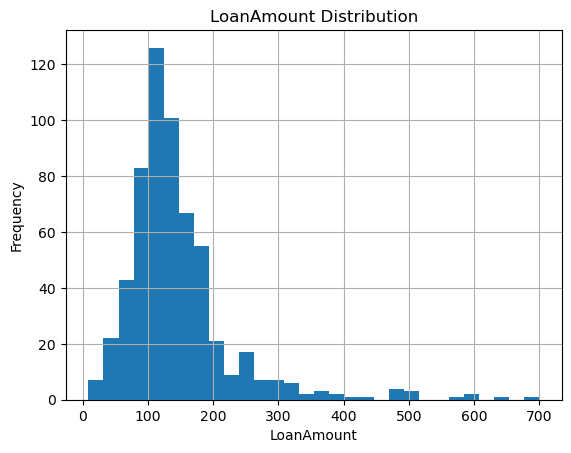

In [411]:
# Plot histogram for each feature
df['LoanAmount'].hist(bins=30)
plt.title('LoanAmount Distribution')
plt.xlabel('LoanAmount')
plt.ylabel('Frequency')
plt.show()

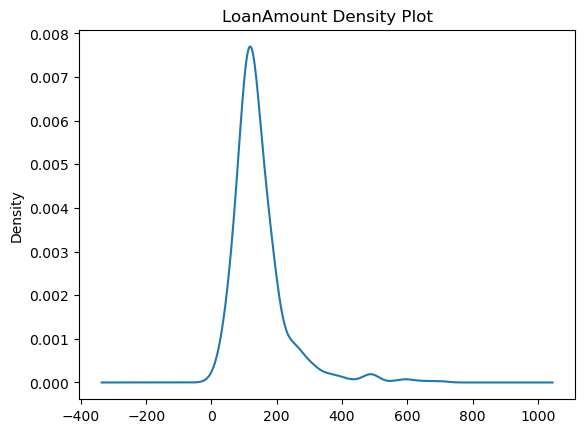

In [412]:
df['LoanAmount'].plot(kind='kde')
plt.title('LoanAmount Density Plot')
plt.show()
# NORMAL DISTRIBUTION USE STANDARD SCALAR

In [413]:
def preprocess_data(df, training=True):

    
    # Add missing value indicators only for columns with missing values
    for col in df.columns:
        if df[col].isnull().any():
            df[f'{col}_is_missing'] = df[col].isnull().astype(int)

    # Drop Loan_ID column if present
    if 'Loan_ID' in df.columns:
        df = df.drop(columns=['Loan_ID'])

    # Handle missing values
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:  # Numeric columns
            df[col] = df[col].fillna(df[col].median())
        elif df[col].dtype == 'object':  # Categorical columns
            df[col] = df[col].fillna(df[col].mode()[0])


    # Convert "3+" in Dependents to 3 and make column numeric
    if 'Dependents' in df.columns:
        df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

    # Encode categorical variables
    # Turning value into number codes
    categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed']
    for col in categorical_columns:
        if col in df.columns:
            df[col] = pd.Categorical(df[col]).codes  # Convert categories to numeric codes

    #One-hot encode 'Property_Area' (if needed)
    # One hot encoding splits properta area values into their own columns so they can have binary values
    if 'Property_Area_Semiurban' in df.columns and 'Property_Area_Urban' in df.columns:
        pass
    else:
        if 'Property_Area' in df.columns:
            df = pd.get_dummies(df, columns=['Property_Area'], drop_first=True)

    # 7. Convert target column 'Loan_Status' to binary (if training)
    if training and 'Loan_Status' in df.columns:
        df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

    # 8. Remove target column for test data (if not training)
    if not training and 'Loan_Status' in df.columns:
        df = df.drop(columns=['Loan_Status'])

    return df

In [414]:
# INSPECT MISSING VALUES

df_train = preprocess_data(df)
df_train.head().T
# print(df.isnull().sum())


,0,1,2,3,4
Gender,1,1,1,1,1
Married,0,1,1,1,0
Dependents,0,1,0,0,0
Education,0,0,0,1,0
Self_Employed,0,0,1,0,0
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0
LoanAmount,128.0,128.0,66.0,120.0,141.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0
Credit_History,1.0,1.0,1.0,1.0,1.0


In [415]:
X = df_train.drop(columns=['Loan_Status'])
y = df_train['Loan_Status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = X_train.columns.tolist()


In [416]:
print(X.shape, X_train.shape, X_val.shape)

(614, 19) (491, 19) (123, 19)


In [417]:
# Baseline: Predict the majority class
baseline_prediction = y_train.mode()[0]  # Most frequent target
baseline_accuracy = (y_train == baseline_prediction).mean()
print(f'Baseline Accuracy: {baseline_accuracy}')

Baseline Accuracy: 0.6965376782077393


In [418]:
# from sklearn.preprocessing import StandardScaler

# # Scale the training and testing features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# # print(X_train)
# # Apply same scaling to validation set
# X_val_scaled = scaler.transform(X_val)         

# # Train Logistic Regression on scaled data
# model = LinearSVC(random_state=42)
# model.fit(X_train_scaled, y_train)

# # Evaluate
# y_pred = model.predict(X_val_scaled)  # Ensure scaled features are used
# accuracy = accuracy_score(y_val, y_pred)
# print(f'LinearSVC Accuracy (Scaled Data): {accuracy}')

In [419]:
# # Scale the training and validation features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Dictionary to store models and their names
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "LinearSVC": LinearSVC(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled if name != "Random Forest" else X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val_scaled if name != "Random Forest" else X_val)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f'{name} Accuracy: {accuracy:.4f}')

Logistic Regression Accuracy: 0.7886
LinearSVC Accuracy: 0.7886
Random Forest Accuracy: 0.7805


In [420]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Tune Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_scaled, y_train)

# Tune LinearSVC
param_grid_svc = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search_svc = GridSearchCV(LinearSVC(random_state=42, max_iter=1000), param_grid_svc, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train_scaled, y_train)

# Tune Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Replace 'auto' with valid options
}
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Use all available processors
)
grid_search_rf.fit(X_train, y_train)

# Compare Results
print(f"Best Logistic Regression Parameters: {grid_search_lr.best_params_}")
print(f"Best Logistic Regression Accuracy: {grid_search_lr.best_score_:.4f}")
print(f"Best LinearSVC Parameters: {grid_search_svc.best_params_}")
print(f"Best LinearSVC Accuracy: {grid_search_svc.best_score_:.4f}")
print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")
print(f"Best Random Forest Accuracy: {grid_search_rf.best_score_:.4f}")


Best Logistic Regression Parameters: {'C': 0.1}
Best Logistic Regression Accuracy: 0.8065
Best LinearSVC Parameters: {'C': 0.01}
Best LinearSVC Accuracy: 0.8085
Best Random Forest Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Accuracy: 0.8126


In [421]:
# Evaluate the best Random Forest model
best_rf = grid_search_rf.best_estimator_
y_val_pred = best_rf.predict(X_val)

# Accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Validation Accuracy: 0.7886
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123

Confusion Matrix:
[[18 25]
 [ 1 79]]


In [422]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    # Create a DataFrame for features and their importances
    df = (pd.DataFrame({
        "features": columns,
        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the top n features
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(df["features"][:n], df["feature_importances"][:n], color='skyblue')
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.set_title("Top Feature Importances")
    ax.invert_yaxis()  # Reverse the order to show the highest importance on top
    plt.tight_layout()
    plt.show()

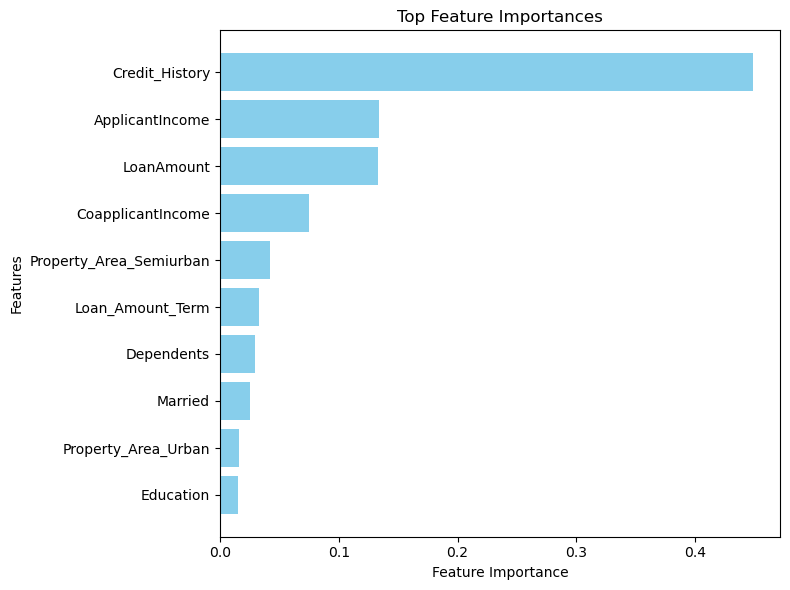

In [423]:
columns = X_train.columns
importances = best_rf.feature_importances_

# Plot the top 10 features
plot_features(columns, importances, n=10)

In [425]:
# Preprocess the test dataset
X_test = preprocess_data(test_df, training=False)

# Add missing columns in the test set with default values (e.g., 0 for missing indicators)
for col in feature_names:
    if col not in X_test.columns:
        X_test[col] = 0  # Default value for missing columns

# Ensure columns are in the same order as the training set
X_test = X_test[feature_names]

# Predict using the best Random Forest model
test_predictions = best_rf.predict(X_test)

# Convert predictions to required format ('Y'/'N')
test_predictions = ['Y' if pred == 1 else 'N' for pred in test_predictions]

# Create a DataFrame for submission
submission = pd.DataFrame({
    'Loan_ID': test_df['Loan_ID'],  # Assuming test.csv includes Loan_ID
    'Loan_Status': test_predictions
})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")

Predictions saved to submission.csv
